# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1TSRJEk1Rido4C3aGh4rPTydF9Q4z6uy-?usp=sharing 

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/APS360_labs/lab3/Lab_3b_Gesture_Dataset/'

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(path + "Trainning", transform=transform)
val_dataset = torchvision.datasets.ImageFolder(path + "Validation", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(path + "Testing", transform=transform)


I splitted the data manually to make the ratio of train data : validation data : test data = 6:2:2

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class CNN(nn.Module):
    # My CNN has 2 covolutional layers and 2 fully connected layers
    # pooling layes is using max-pooling with size of 2x2
    # Using Relu activation function

    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5) #input channel = 3; output channel = 5; kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5) #input channel = 5; output channel = 10; kernel size = 5
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9) #32 hidden units, 9 outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_accuracy(net, loader):
    correct = 0
    total = 0
    for inputs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        output = net(inputs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train(net, train_dataset, val_dataset, batch_size=128, num_epochs=20, learning_rate=0.001):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss() #cross entropy loss function
    optimizer = optim.Adam(net.parameters(), lr=learning_rate) #Adam optimizer

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # Train the network
    print("Start...")
    # Loop over the data iterator and sample a new batch of training data
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for inputs, labels in iter(train_loader): 

            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()    
            # Forward pass, backward pass, and optimize     
            outputs = net(inputs)             
            loss = criterion(outputs, labels) 
            loss.backward()               
            optimizer.step()  
        
        # Trainning and validtion accuracy
        train_acc[epoch] = get_accuracy(net, train_loader)
        val_acc[epoch] = get_accuracy(net, val_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    epochs = np.arange(0, num_epochs)

    plt.plot(epochs, train_acc)
    plt.title("Training Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()

    plt.plot(epochs, val_acc)
    plt.title("Validation Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()

I chose Adam optimizer and cross entropy loss function is because in the lecture we detailed talk about their advantages, and they are generally used in the area of image processing.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def train_overfit(net, train_loader, batch_size=27, num_epochs=20, learning_rate = 0.001):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        for inputs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()    
            # Forward pass, backward pass, and optimize     
            outputs = net(inputs)             
            loss = criterion(outputs, labels) 
            loss.backward()               
            optimizer.step()              

        # trainning accuracy
        train_acc[epoch] = get_accuracy(net, train_loader)
        print("Epoch: {}, Accuracy: {}".format(epoch, train_acc[epoch]))
                    
    return train_acc

In [ ]:
overfit_path = '/content/gdrive/My Drive/Colab Notebooks/APS360_labs/lab3/Lab_3b_Gesture_Dataset/Overfit'

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

overfit_dataset = torchvision.datasets.ImageFolder(overfit_path, transform=transform)

overfit_loader = torch.utils.data.DataLoader(overfit_dataset, batch_size=27, num_workers=1, shuffle=True)


In [ ]:
CNN1 = CNN()
if use_cuda and torch.cuda.is_available():
  CNN1.cuda()

train_overfit(CNN1, small_loader, num_epochs=20);

Epoch: 0, Accuracy: 0.1111111111111111
Epoch: 1, Accuracy: 0.1111111111111111
Epoch: 2, Accuracy: 0.14814814814814814
Epoch: 3, Accuracy: 0.4444444444444444
Epoch: 4, Accuracy: 0.5185185185185185
Epoch: 5, Accuracy: 0.6666666666666666
Epoch: 6, Accuracy: 0.7407407407407407
Epoch: 7, Accuracy: 0.9259259259259259
Epoch: 8, Accuracy: 0.9629629629629629
Epoch: 9, Accuracy: 0.9259259259259259
Epoch: 10, Accuracy: 1.0
Epoch: 11, Accuracy: 0.9259259259259259
Epoch: 12, Accuracy: 1.0
Epoch: 13, Accuracy: 1.0
Epoch: 14, Accuracy: 1.0
Epoch: 15, Accuracy: 1.0
Epoch: 16, Accuracy: 1.0
Epoch: 17, Accuracy: 1.0
Epoch: 18, Accuracy: 1.0
Epoch: 19, Accuracy: 1.0


### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

The 3 hyperparameters I chose are: batch size, learning rate, kernal size of layers

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

Start...
Epoch 0: Train acc: 0.31815091774303195 |Validation acc: 0.2604166666666667
Epoch 1: Train acc: 0.39768864717878993 |Validation acc: 0.35
Epoch 2: Train acc: 0.6261046906866078 |Validation acc: 0.5583333333333333
Epoch 3: Train acc: 0.6866077498300476 |Validation acc: 0.5854166666666667
Epoch 4: Train acc: 0.7307953772943576 |Validation acc: 0.6229166666666667
Epoch 5: Train acc: 0.7552685248130524 |Validation acc: 0.60625
Epoch 6: Train acc: 0.761386811692726 |Validation acc: 0.6
Epoch 7: Train acc: 0.7980965329707682 |Validation acc: 0.6041666666666666
Epoch 8: Train acc: 0.822569680489463 |Validation acc: 0.6395833333333333
Epoch 9: Train acc: 0.8273283480625425 |Validation acc: 0.6166666666666667
Epoch 10: Train acc: 0.8416043507817811 |Validation acc: 0.6395833333333333
Epoch 11: Train acc: 0.8565601631543168 |Validation acc: 0.6208333333333333
Epoch 12: Train acc: 0.8857919782460911 |Validation acc: 0.64375
Epoch 13: Train acc: 0.9014276002719238 |Validation acc: 0.6375


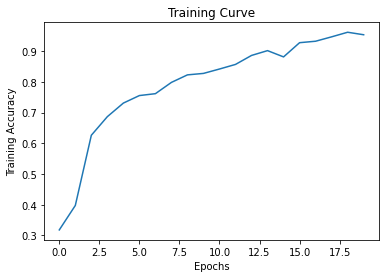

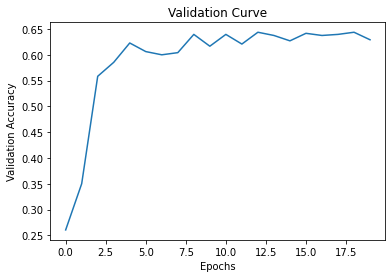

In [ ]:
# 1. Default Setting: batch_size=128, num_epochs=20, learning_rate=0.001
CNN2 = CNN()
if use_cuda and torch.cuda.is_available():
    CNN2.cuda()

train(CNN2, train_dataset, val_dataset)

Start...
Epoch 0: Train acc: 0.9055064581917063 |Validation acc: 0.6208333333333333
Epoch 1: Train acc: 0.9014276002719238 |Validation acc: 0.6208333333333333
Epoch 2: Train acc: 0.9347382732834806 |Validation acc: 0.61875
Epoch 3: Train acc: 0.9299796057104011 |Validation acc: 0.6166666666666667
Epoch 4: Train acc: 0.9456152277362339 |Validation acc: 0.6520833333333333
Epoch 5: Train acc: 0.9483344663494222 |Validation acc: 0.6416666666666667
Epoch 6: Train acc: 0.9612508497620667 |Validation acc: 0.6291666666666667
Epoch 7: Train acc: 0.9660095173351462 |Validation acc: 0.6125
Epoch 8: Train acc: 0.973487423521414 |Validation acc: 0.6291666666666667
Epoch 9: Train acc: 0.9714479945615228 |Validation acc: 0.6291666666666667


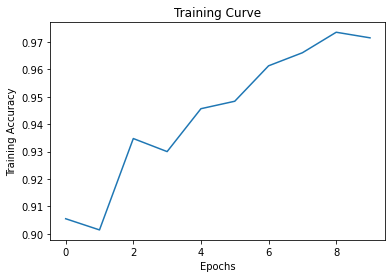

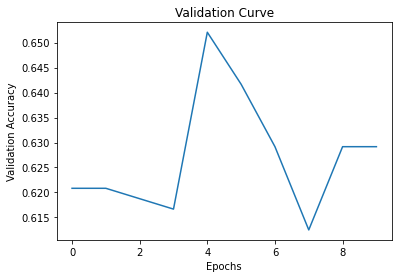

In [ ]:
# 2. Increases in batch size
CNN3 = CNN()
if use_cuda and torch.cuda.is_available():
    CNN3.cuda()

train(CNN3, train_dataset, val_dataset, batch_size=512, num_epochs=10, learning_rate=0.001)

Start...
Epoch 0: Train acc: 0.12372535690006799 |Validation acc: 0.125
Epoch 1: Train acc: 0.2868796736913664 |Validation acc: 0.24791666666666667
Epoch 2: Train acc: 0.5003399048266486 |Validation acc: 0.36041666666666666
Epoch 3: Train acc: 0.592114208021754 |Validation acc: 0.48333333333333334
Epoch 4: Train acc: 0.6682528891910265 |Validation acc: 0.54375
Epoch 5: Train acc: 0.7294357579877634 |Validation acc: 0.6145833333333334
Epoch 6: Train acc: 0.7627464309993202 |Validation acc: 0.61875
Epoch 7: Train acc: 0.7403127124405167 |Validation acc: 0.56875
Epoch 8: Train acc: 0.7824609109449354 |Validation acc: 0.59375
Epoch 9: Train acc: 0.7709041468388851 |Validation acc: 0.5833333333333334


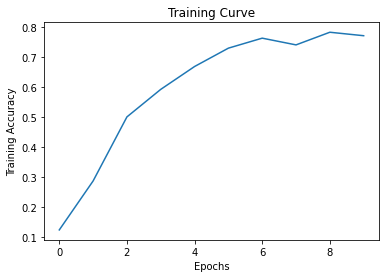

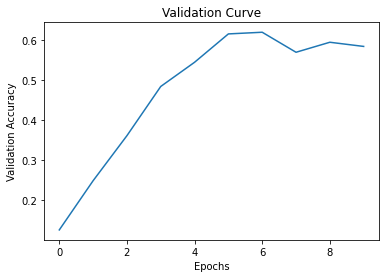

In [ ]:
# 3. Increases in learning rate
CNN4 = CNN()
if use_cuda and torch.cuda.is_available():
    CNN4.cuda()

train(CNN4, train_dataset, val_dataset, batch_size=128, num_epochs=10, learning_rate=0.003)

In [ ]:
class CNN_k(nn.Module):
      def __init__(self):
          self.name = "CNN_k"
          super(CNN_k, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
          self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
          self.conv2 = nn.Conv2d(5, 10, 11) #in_channels=5, out_chanels=10, kernel_size=11
          self.fc1 = nn.Linear(10*50*50, 32)
          self.fc2 = nn.Linear(32, 9)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x))) #relu activation function
          x = self.pool(F.relu(self.conv2(x))) #relu activation function
          x = x.view(-1, 10*50*50)
          x = F.relu(self.fc1(x)) #relu activation function
          x = self.fc2(x)
          return x

Start...
Epoch 0: Train acc: 0.2794017675050986 |Validation acc: 0.24791666666666667
Epoch 1: Train acc: 0.37661454792658056 |Validation acc: 0.30416666666666664
Epoch 2: Train acc: 0.6206662134602311 |Validation acc: 0.5208333333333334
Epoch 3: Train acc: 0.7335146159075459 |Validation acc: 0.6083333333333333
Epoch 4: Train acc: 0.7335146159075459 |Validation acc: 0.6166666666666667
Epoch 5: Train acc: 0.7382732834806254 |Validation acc: 0.625
Epoch 6: Train acc: 0.7688647178789939 |Validation acc: 0.6458333333333334
Epoch 7: Train acc: 0.778382053025153 |Validation acc: 0.6125
Epoch 8: Train acc: 0.769544527532291 |Validation acc: 0.6395833333333333
Epoch 9: Train acc: 0.7974167233174712 |Validation acc: 0.6666666666666666
Epoch 10: Train acc: 0.8252889191026512 |Validation acc: 0.66875
Epoch 11: Train acc: 0.8450033990482665 |Validation acc: 0.6854166666666667
Epoch 12: Train acc: 0.8395649218218899 |Validation acc: 0.6666666666666666
Epoch 13: Train acc: 0.8429639700883752 |Validat

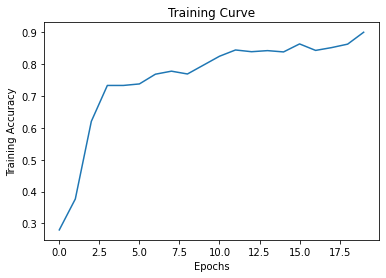

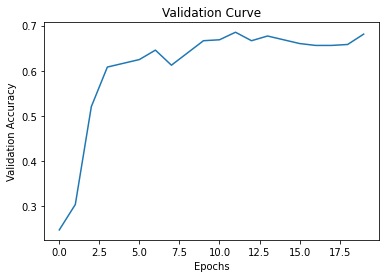

In [ ]:
# 4. Increases in kernal size
CNN5 = CNN_k()
if use_cuda and torch.cuda.is_available():
    CNN5.cuda()

train(CNN5, train_dataset, val_dataset, batch_size=128, num_epochs=20, learning_rate=0.001)

Start...
Epoch 0: Train acc: 0.1114887831407206 |Validation acc: 0.10833333333333334
Epoch 1: Train acc: 0.1230455472467709 |Validation acc: 0.1125
Epoch 2: Train acc: 0.256288239292998 |Validation acc: 0.20833333333333334
Epoch 3: Train acc: 0.2460910944935418 |Validation acc: 0.21875
Epoch 4: Train acc: 0.33854520734194427 |Validation acc: 0.26666666666666666
Epoch 5: Train acc: 0.41196464989802856 |Validation acc: 0.33541666666666664
Epoch 6: Train acc: 0.34466349422161796 |Validation acc: 0.29791666666666666
Epoch 7: Train acc: 0.4969408565601632 |Validation acc: 0.39166666666666666
Epoch 8: Train acc: 0.46498980285520053 |Validation acc: 0.4041666666666667
Epoch 9: Train acc: 0.5411284840244731 |Validation acc: 0.43333333333333335


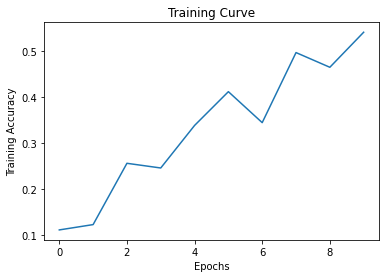

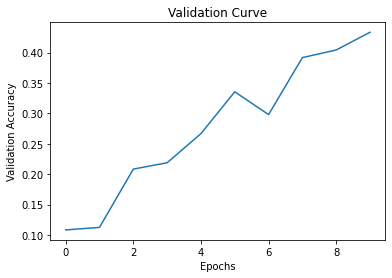

In [ ]:
# 5. Increase in batch_size & kernal size
CNN6 = CNN_k()
if use_cuda and torch.cuda.is_available():
    CNN6.cuda()

train(CNN6, train_dataset, val_dataset, batch_size=512, num_epochs=10, learning_rate=0.001)

Start...
Epoch 0: Train acc: 0.3555404486743712 |Validation acc: 0.3020833333333333
Epoch 1: Train acc: 0.6356220258327668 |Validation acc: 0.54375
Epoch 2: Train acc: 0.7226376614547927 |Validation acc: 0.5645833333333333
Epoch 3: Train acc: 0.6961250849762066 |Validation acc: 0.5520833333333334
Epoch 4: Train acc: 0.761386811692726 |Validation acc: 0.5958333333333333
Epoch 5: Train acc: 0.7912984364377974 |Validation acc: 0.6395833333333333
Epoch 6: Train acc: 0.8069340584636302 |Validation acc: 0.65
Epoch 7: Train acc: 0.8416043507817811 |Validation acc: 0.65625
Epoch 8: Train acc: 0.8599592114208022 |Validation acc: 0.68125
Epoch 9: Train acc: 0.8959891230455472 |Validation acc: 0.6708333333333333
Epoch 10: Train acc: 0.9340584636301835 |Validation acc: 0.6791666666666667
Epoch 11: Train acc: 0.9632902787219578 |Validation acc: 0.6854166666666667
Epoch 12: Train acc: 0.981645139360979 |Validation acc: 0.6854166666666667
Epoch 13: Train acc: 0.9870836165873556 |Validation acc: 0.704

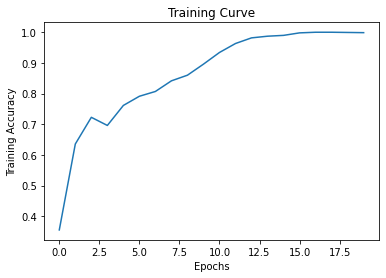

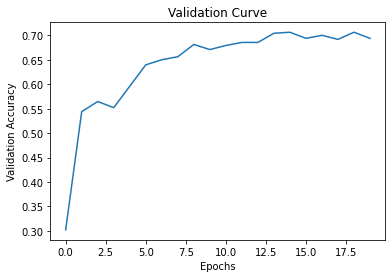

In [ ]:
# 6. Increase in learning rate & kernal size
CNN7 = CNN_k()
if use_cuda and torch.cuda.is_available():
    CNN7.cuda()

train(CNN7, train_dataset, val_dataset, batch_size=128, num_epochs=20, learning_rate=0.003)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
#The best model I got is when batch_size=128, num_epochs=19, learning_rate=0.003, 
#kernal size = 5 in first convolutional layer, and kernal size = 11 in second convolutional layer
#The best validation accuracy I can get is 70.625%

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=1, shuffle=True)
get_accuracy(CNN7, test_loader)

0.7020833333333333

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
import os

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

train_loader_f = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
val_loader_f = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=1, shuffle=True)
test_loader_f = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

path_f = '/content/gdrive/My Drive/Colab Notebooks/APS360_labs/lab3/features'

n = 0
for img, label in train_loader_f:
    features = alexnet.features(img)
    f_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = path_f + '/train'
    folder_name = "/".join([folder_name, str(classes[label])])
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    torch.save(f_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
n = 0
for img, label in val_loader_f:
    features = alexnet.features(img)
    f_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = path_f + '/valid' 
    folder_name = "/".join([folder_name, str(classes[label])])
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    torch.save(f_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
n = 0
for img, label in test_loader_f:
    features = alexnet.features(img)
    f_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = path_f + '/test'
    folder_name = "/".join([folder_name, str(classes[label])])
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    torch.save(f_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [ ]:
train_f = torchvision.datasets.DatasetFolder(path_f + '/train', loader=torch.load, extensions=('.tensor'))
valid_f = torchvision.datasets.DatasetFolder(path_f + '/valid', loader=torch.load, extensions=('.tensor'))
test_f = torchvision.datasets.DatasetFolder(path_f + '/test', loader=torch.load, extensions=('.tensor'))

train_loader_ft = torch.utils.data.DataLoader(train_f, batch_size=32, num_workers=1, shuffle=True)
val_loader_ft = torch.utils.data.DataLoader(valid_f, batch_size=32, num_workers=1, shuffle=True)
test_loader_ft = torch.utils.data.DataLoader(test_f, batch_size=32, num_workers=1, shuffle=True)

In [ ]:
class CNN_t(nn.Module):
    def __init__(self):
        super(CNN_t, self).__init__()
        self.name = "CNN_t"
        self.conv1 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, 9) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x  

I chose to use 1 convolution layer and 1 max-pooling layer, the reason to decreases 1 layer compare to the original CNN model is because the feature of the data have already been extracted by AlexNet once, I think it is no need to do the second layer to extract the extra features. 
The activation I used is Relu.


### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

Start...
Epoch 0: Train acc: 0.8956241032998565 |Validation acc: 0.7429805615550756
Epoch 1: Train acc: 0.9687948350071736 |Validation acc: 0.785097192224622
Epoch 2: Train acc: 0.9860114777618364 |Validation acc: 0.7926565874730022
Epoch 3: Train acc: 0.9949784791965567 |Validation acc: 0.7840172786177105
Epoch 4: Train acc: 0.9949784791965567 |Validation acc: 0.8056155507559395
Epoch 5: Train acc: 0.9992826398852224 |Validation acc: 0.8012958963282938
Epoch 6: Train acc: 0.9992826398852224 |Validation acc: 0.8153347732181425
Epoch 7: Train acc: 0.9992826398852224 |Validation acc: 0.7958963282937365
Epoch 8: Train acc: 1.0 |Validation acc: 0.8120950323974082
Epoch 9: Train acc: 1.0 |Validation acc: 0.8196544276457883
Epoch 10: Train acc: 1.0 |Validation acc: 0.8153347732181425
Epoch 11: Train acc: 1.0 |Validation acc: 0.8153347732181425
Epoch 12: Train acc: 1.0 |Validation acc: 0.8207343412526998


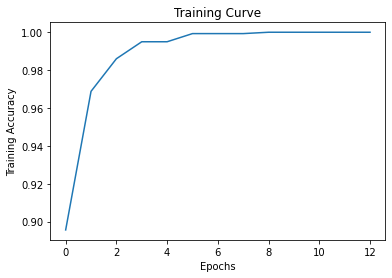

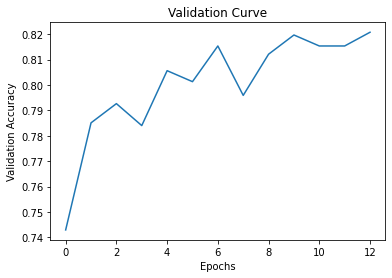

In [ ]:
transfer = CNN_t()
if use_cuda and torch.cuda.is_available():
  transfer.cuda()

train(transfer, train_f, valid_f, batch_size=128, num_epochs=13)

The test accuracy aquired from the best model using transfer learning is 82.07%, which is much higher compared to the 70.625% test accuracy obtained from the best model using CNN

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
get_accuracy(transfer, test_loader_ft)

0.8625

The test accuracy aquired from the best model using transfer learning is 86.25%, which is much higher compared to the 70.208% test accuracy obtained from the best model using CNN

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

addition_loader_f = torch.utils.data.DataLoader(overfit_dataset, batch_size=1, num_workers=1, shuffle=True)

path_f = '/content/gdrive/My Drive/Colab Notebooks/APS360_labs/lab3/features'

n = 0
for img, label in addition_loader_f:
    features = alexnet.features(img)
    f_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = path_f + '/addition'
    folder_name = "/".join([folder_name, str(classes[label])])
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    torch.save(f_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
addition_f = torchvision.datasets.DatasetFolder(path_f + '/addition', loader=torch.load, extensions=('.tensor'))
addition_loader_ft = torch.utils.data.DataLoader(addition_f, batch_size=32, num_workers=1, shuffle=True)
get_accuracy(transfer, addition_loader_ft)

0.8513


The test accuracy aquired from the best model using the small addition dataset is 85.13%, which is a bit lower compared to the 86.25% obtained in part4(d). 
This is an expected result because the model is selected based on the best validation accuracy, and it should work better in the validation data and work not as well as it when it encounters some new data it never seen before.
But in my opinion, this model works pretty well, there is only a small decrease in accuracy.
